In [43]:
import os
import matplotlib.pyplot    as plt
import numpy                as np

In [44]:
def get_x_t(path):

    with open(path[2]) as file:
        lines = file.readlines()
        real_dict = {}
        time = lines[0].split('T')[1]
        parts = time.split(':')
        char = '-'

        if ("+") in lines[0]:
            char = '+'
            
        min_t = float(parts[1]) * 60  + float(parts[0]) * 3600 + float(parts[2].split(char)[0]) 
        for line in lines:
            if len(line) > 40:
                time = line.split('T')[1]
                x = float(line.split(',')[0])
                parts = time.split(':')
                if len(parts) == 4:
                    t = float(parts[0]) * 3600 + float(parts[1]) * 60 + float(parts[2].split(char)[0]) - min_t
                    real_dict[x] = t

    with open(path[1]) as file:
        lines = file.readlines()
        interpolated_dict = {}
        time = lines[0].split('T')[1]
        parts = time.split(':')
        
        for line in lines:
            if len(line) > 40:
                time = line.split('T')[1]
                x = float(line.split(',')[0])
                parts = time.split(':')
                if len(parts) == 4:
                    t = float(parts[0]) * 3600 + float(parts[1]) * 60 + float(parts[2].split(char)[0]) - min_t
                    interpolated_dict[x] = t

    
    
    real_keys = list(real_dict.keys())
    real_values = list(real_dict.values())

    if real_keys[-1] > real_keys[0]:
        real_dict = {real_keys[i]: real_values[i] for i in range(len(real_keys) - 1) if real_keys[i + 1] >= real_keys[i]}
    else:
        real_dict = {real_keys[i]: real_values[i] for i in range(len(real_keys) - 1) if real_keys[i + 1] <= real_keys[i]}
    
    print(f"{path[0]} loaded")
    return [path[0],real_dict, interpolated_dict]

def velocity_uncertainty(real_dict,fake_dict):

    dx_uncertainty = np.sqrt(0.005**2 + 0.005**2)
    dt_uncertainty = np.sqrt(0.008**2 + 0.008**2)
    
    real_positions = list(real_dict.keys())[::-1]
    real_times = list(real_dict.values())[::-1]
    lidar_positions= list(fake_dict.keys())[::-1]

    dt = list(np.diff(real_times))
    dx = list(np.diff(real_positions))
    dt.append(dt[-1])
    dx.append(dx[-1])

    dt = np.array(dt)
    dx = np.array(dx)

    uncertainties = np.sqrt((dx_uncertainty/dt)**2 +  ((dx/(dt**2))*dt_uncertainty)**2)

    uncertainties_interp = []

    for x in lidar_positions:
        if x <= np.max(real_positions):
            index = np.searchsorted(real_positions,x, side = 'right') - 1
            uncertainties_interp.append(uncertainties[index])


    return uncertainties_interp, uncertainties

In [45]:
class FileParser:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.box_folders = []

    def find_folders(self):
        for root, dirs, files in os.walk(self.root_dir):
            for dir_name in dirs:
                full_part_path = os.path.join(root, dir_name)
                fake_x_path = None
                real_x_path = None
                
                for file_name in os.listdir(full_part_path):
                        file_path = os.path.join(full_part_path, file_name)

                        if os.path.isfile(file_path) and os.path.getsize(file_path) > 1:
                            if file_name.endswith("real.dbg"):
                                real_x_path = file_path
                            elif file_name.endswith(".dbg"):
                                fake_x_path = file_path
                        if fake_x_path is not None and real_x_path is not None:
                            self.box_folders.append((full_part_path, fake_x_path, real_x_path))


    def get_box_folders(self):
        self.find_folders()
        return self.box_folders


parser = FileParser(r"\\192.168.1.63\g\CoreScans")
parser = FileParser(r"C:\Users\eashenhurst\Desktop\local scans\auzzy rocks")
paths_list = parser.get_box_folders()

for name, fake_x_path, real_x_path in paths_list:
    print(f"Part: {name}")
    print(f"  interpolated dbg: {fake_x_path if fake_x_path else 'None'}")
    print(f"  real dbg: {real_x_path if real_x_path else 'None'}")
print(f"{len(paths_list)} scans found")


Part: C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_1
  interpolated dbg: C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_1\LIDAR_001.dbg
  real dbg: C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_1\LIDAR_001_real.dbg
Part: C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_1
  interpolated dbg: C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_1\LIDAR_001.dbg
  real dbg: C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_1\LIDAR_001_real.dbg
Part: C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_2
  interpolated dbg: C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_2\LIDAR_002.dbg
  real dbg: C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_2\LIDAR_002_real.dbg
Part: C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_3
  interpolated dbg: C:\Users\eashenhurst\Desktop\local scans\auzzy rock

In [46]:
position_dicts = []

for path in paths_list:
    if None not in path:
        position_dicts.append(get_x_t(path))

C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_1 loaded
C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_1 loaded
C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_2 loaded
C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_3 loaded
C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_4 loaded
C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_5 loaded


In [47]:
all_dt_real = []
all_dt_interp = []

for dict in position_dicts:
    x_real = list(dict[1].keys())
    t_real = list(dict[1].values())
    t_fake = list(dict[2].values())
    x_fake = list(dict[2].keys())
    dt_fake = np.diff(t_fake)
    v_real = np.abs(np.diff(x_fake)/dt_fake)
    v_real = v_real[200:-200]

    print(dict[0])
    vmean = np.nanmean(v_real)
    dtmean = np.nanmean(dt_fake)
    print(f"  {vmean}")
    print(f"  {dtmean}")
    print(f"  {(vmean*dtmean)}")



C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_1
  50.11417072635206
  0.019616196276335027
  0.9830494091938851
C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_1
  50.11417072635206
  0.019616196276335027
  0.9830494091938851
C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_2
  50.11953800560824
  0.019540608233028334
  0.9793662569879649
C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_3
  50.11616355093216
  0.019910278016609835
  0.9978267494249476
C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_4
  50.131957187653335
  0.019715492015579438
  0.9883762016585496
C:\Users\eashenhurst\Desktop\local scans\auzzy rocks\Core_Box_1_Part_5
  50.1260141435672
  0.02012603125628159
  1.0088377274062463


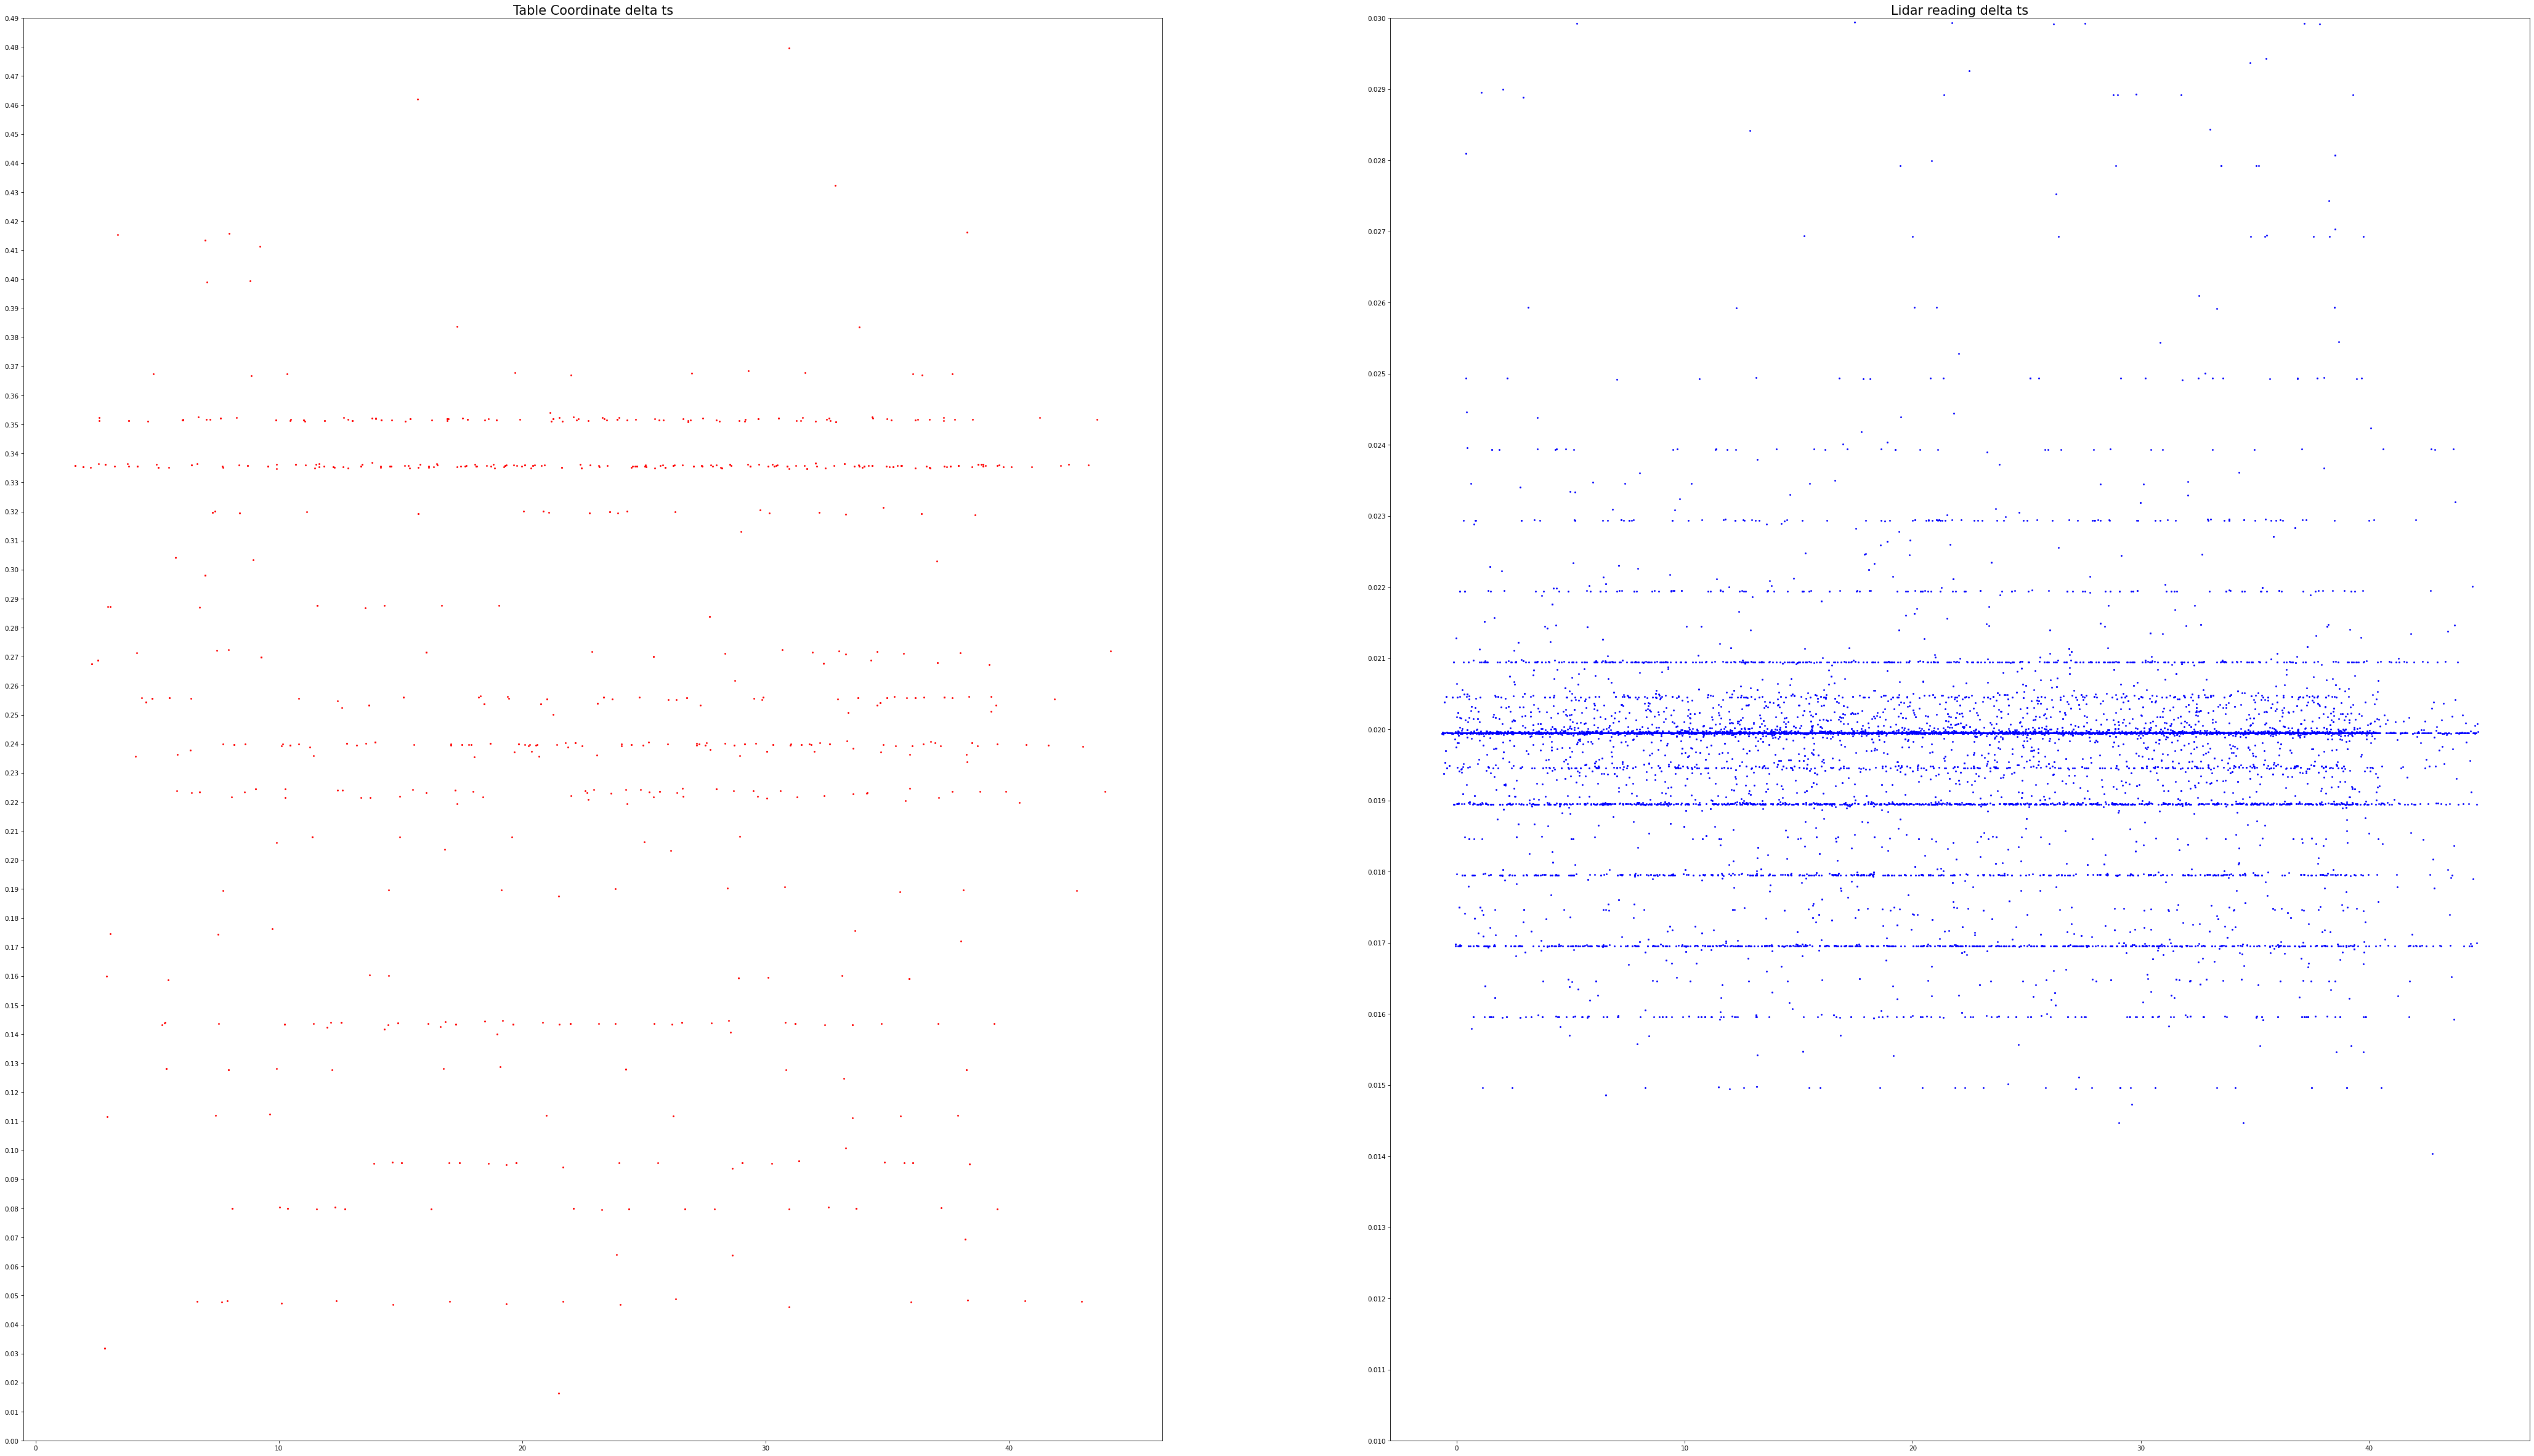

In [48]:
all_t_real = []
all_dt_real = []
all_t_interp = []
all_dt_interp = []

for dict in position_dicts:
    x_real = np.array(list(dict[1].keys()))
    t_real = np.array(list(dict[1].values()))
    dt_real = np.diff(t_real)

    all_t_real.extend(t_real[:-1])
    all_dt_real.extend(dt_real)

    x_interp = np.array(list(dict[2].keys()))
    t_interp = np.array(list(dict[2].values()))
    dt_interp = np.diff(t_interp)

    all_t_interp.extend(t_interp[:-1])
    all_dt_interp.extend(dt_interp)

fig = plt.figure(figsize=(70, 40), dpi=75)
gs = fig.add_gridspec(1, 2, hspace=0.025)
ax = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


ax.scatter(all_t_real, all_dt_real, color="red", s=3)
ax2.scatter(all_t_interp, all_dt_interp, color="blue", s=3)

ax.set_ybound(0, 0.1)
ax.set_yticks(np.arange(0, 0.5, 0.01))
ax2.set_ybound(0.01, 0.03)
ax2.set_yticks(np.arange(0.01, 0.031, 0.001))

ax.set_title("Table Coordinate delta ts", fontsize=20)
ax2.set_title("Lidar reading delta ts", fontsize=20)

plt.show()


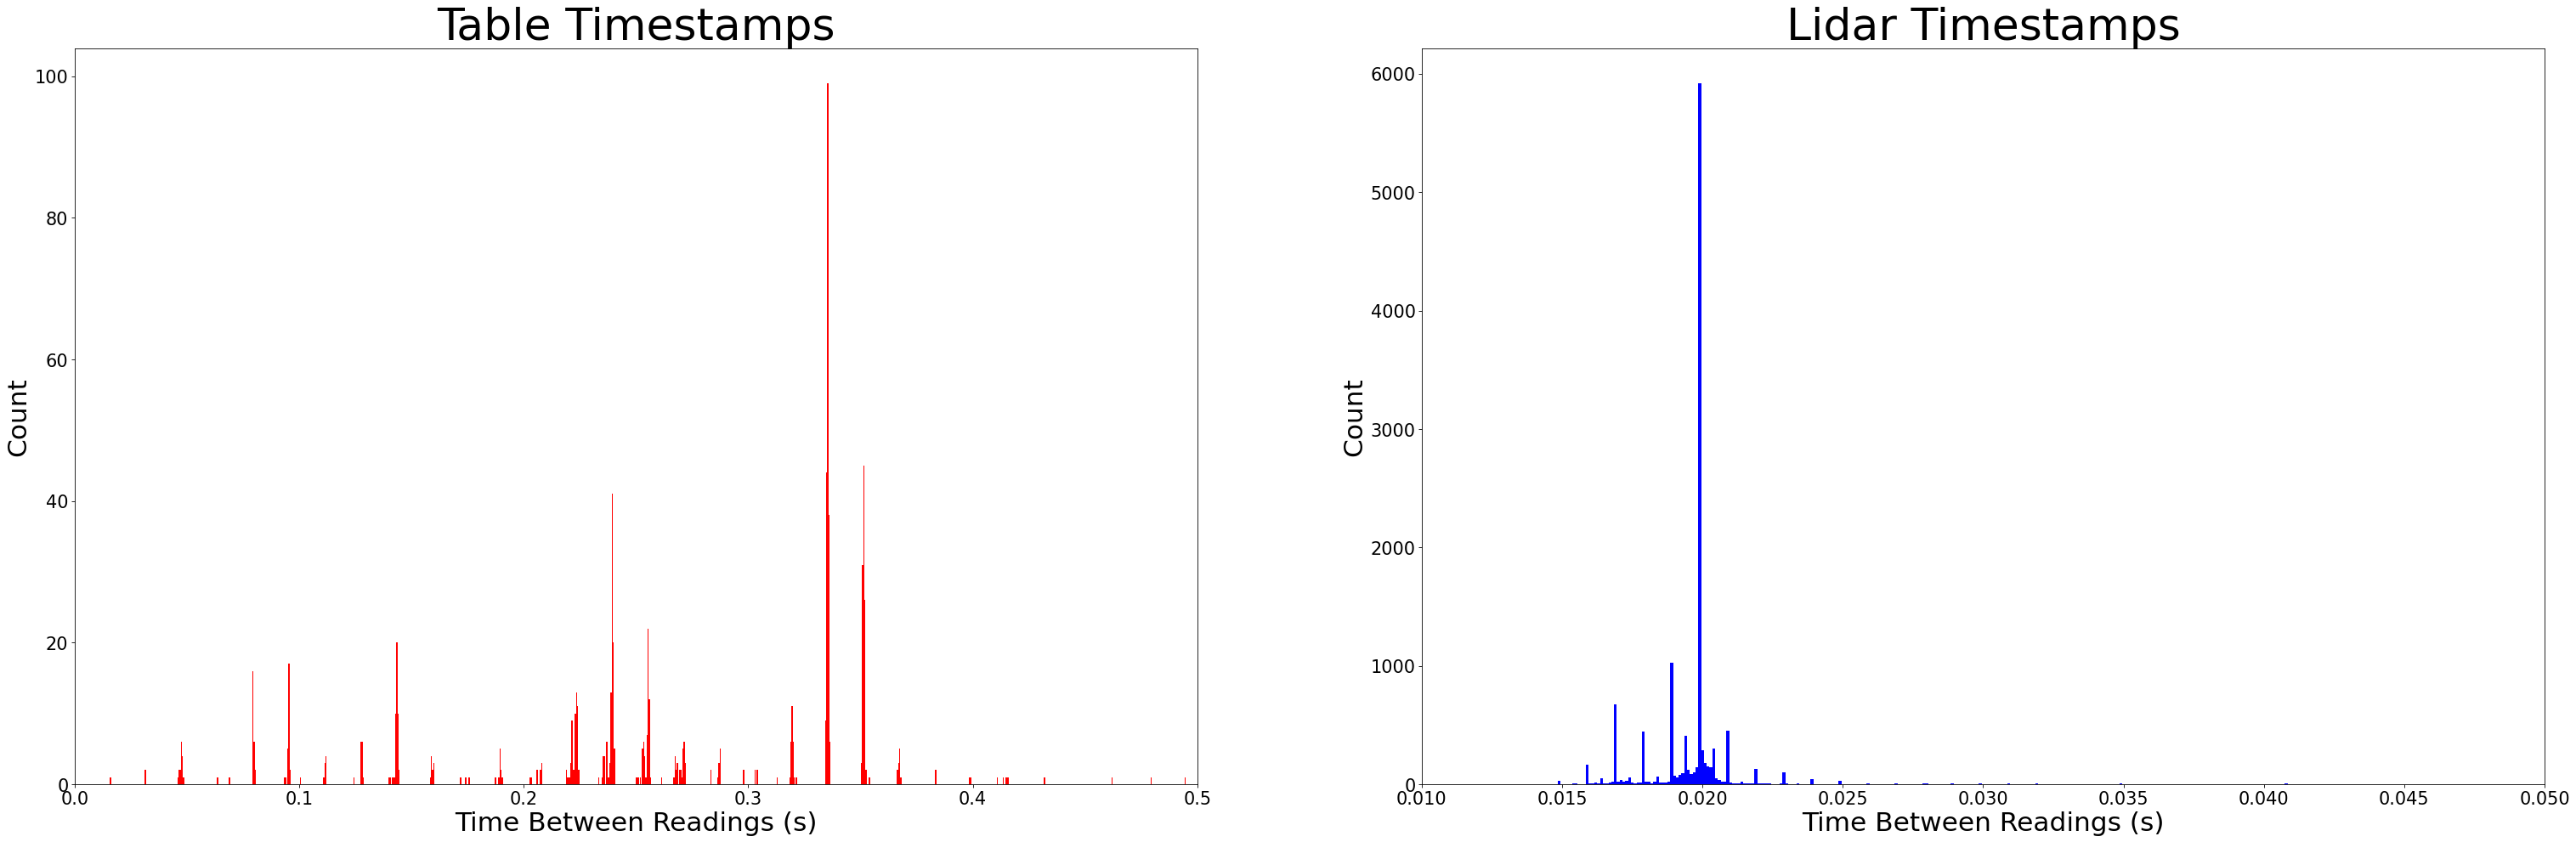

In [49]:
all_dt_real = []
all_dt_interp = []

for dict in position_dicts:
    x_real = np.array(list(dict[1].keys()))
    t_real = np.array(list(dict[1].values()))
    dt_real = np.diff(t_real)
    all_dt_real.extend(dt_real)

    x_interp = np.array(list(dict[2].keys()))
    t_interp = np.array(list(dict[2].values()))
    dt_interp = np.diff(t_interp)
    all_dt_interp.extend(dt_interp)

fig = plt.figure(figsize=(50, 15), dpi=75)
gs = fig.add_gridspec(1, 2, hspace=0.025)
ax = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

bins_real = np.arange(0, max(all_dt_real) + 0.0001, 0.0005)
bins_interp = np.arange(0, max(all_dt_interp) + 0.0001, 0.0001)

counts_real, _ = np.histogram(all_dt_real, bins=bins_real)
counts_interp, _ = np.histogram(all_dt_interp, bins=bins_interp)

ax.bar(bins_real[:-1], counts_real, width=np.diff(bins_real), color="red")
ax2.bar(bins_interp[:-1], counts_interp, width=np.diff(bins_interp), color="blue")

ax.set_xbound(0, 0.5)
ax2.set_xbound(0.01, 0.05)
ax.tick_params(axis='both', labelsize=20)
ax2.tick_params(axis='both', labelsize=20)

ax.set_title("Table Timestamps", fontsize=50)
ax2.set_title("Lidar Timestamps", fontsize=50)

ax.set_xlabel("Time Between Readings (s)", fontsize=30)
ax.set_ylabel("Count", fontsize=30)

ax2.set_xlabel("Time Between Readings (s)", fontsize=30)
ax2.set_ylabel("Count", fontsize=30)

plt.show()


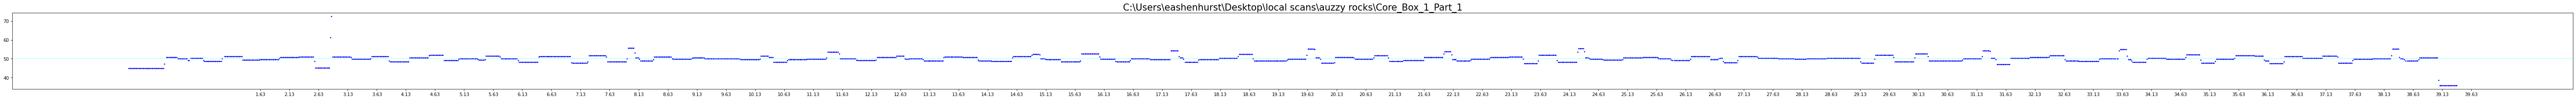

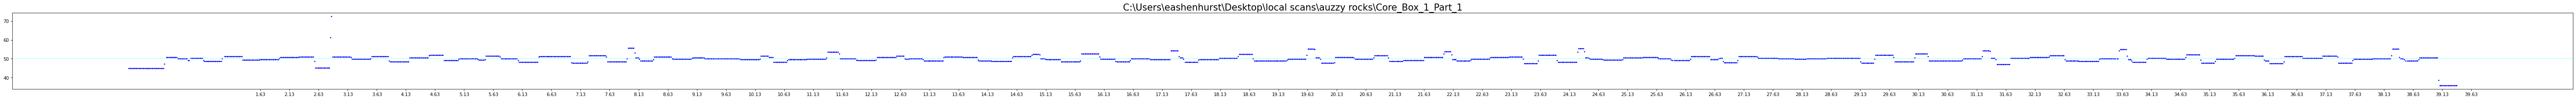

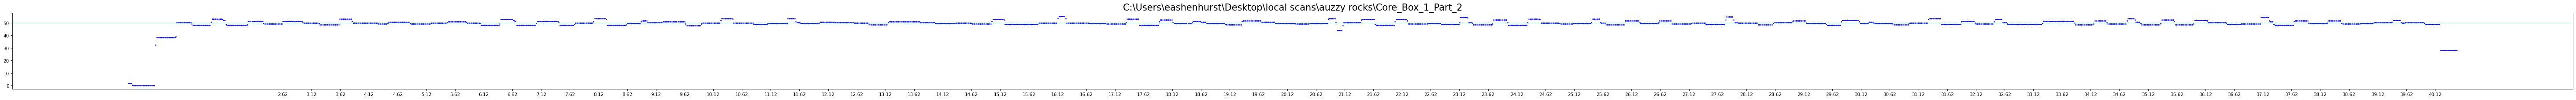

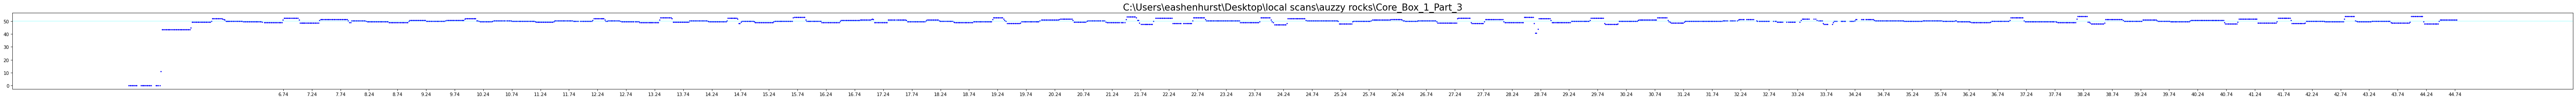

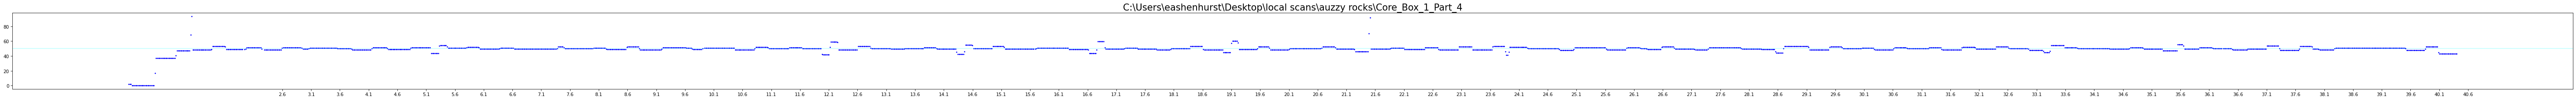

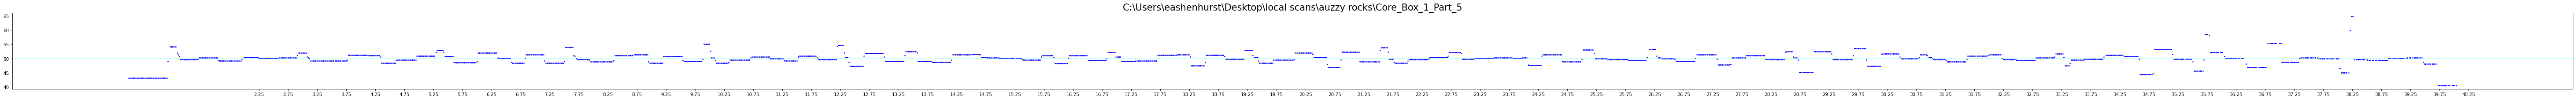

In [50]:


for dict in position_dicts:
    fig = plt.figure(figsize=(100,3) , dpi=75)
    gs = fig.add_gridspec(1, 1, hspace=0.025)

    ax = fig.add_subplot(gs[0,0])

    x_real = list(dict[1].keys())
    t_real = list(dict[1].values())
    dt_real = np.diff(t_real)
    v_real = np.abs(np.diff(x_real)/dt_real)
    t_real = t_real[:-1]

    x_interp = list(dict[2].keys())
    t_interp = list(dict[2].values())
    dt_interp = np.diff(t_interp)
    v_interp = np.abs(np.diff(x_interp)/dt_interp)
    t_interp = t_interp[:-1]

    unc_real = list(velocity_uncertainty(dict[1],dict[2])[1])[::-1]

    unc_real = unc_real[1:]

    t_interp = np.array(t_interp)
    t_real = np.array(t_real)


    ax.axhline(y= 50, color = 'cyan',linestyle = 'solid', linewidth = 1.5, alpha = 0.25)
    ax.scatter(t_interp,v_interp,color = "blue", s = 2.5)
    #ax.vlines(t_real,ymin = v_real - unc_real, ymax = v_real + unc_real, color = "green", alpha = 1, linewidth = 0.5)
    #ax.scatter(t_real,v_real, color = "Red", s = 7)
    #ax.set_ylim(40, 60)
    ax.set_xticks(np.arange(min(t_real), max(t_real) + 1, 0.5))


    ax.set_title(dict[0], fontsize=20)
    plt.show()